In [15]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12 # or 54
lookback = 12
chosen_stocks = [
    "AAPL",
    "ADM",
    "AFL",
    "AIG",
    "ALL",
    "AMZN",
    "AXP",
    "COF",
    "COST",
    "CVS",
    "DIS",
    "F",
    "FDX",
    "HAL",
    "HIG",
    "LOW",
    "MET",
    "PGR",
    "PRU",
    "SBUX",
    "SPC",
    "WAG"
] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [16]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(3454, 12)


In [17]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 264)


In [18]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(146, 22)


In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

(157, 264)


In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [ ]:
from sklearn.model_selection import PredefinedSplit

validation_months = 24
test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - validation_months + lookback].reshape(split_point - validation_months + lookback, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - validation_months + lookback].reshape(split_point - validation_months + lookback, len(chosen_stocks))
x_validate = x[split_point - validation_months:split_point].reshape(validation_months, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - validation_months:split_point].reshape(validation_months, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

In [28]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=1024, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=1024, return_sequences=True, kernel_regularizer=l1_l2(0.0001)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=1024, return_sequences=False, kernel_regularizer=l1_l2(0.0001)))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation="relu", kernel_regularizer=l1_l2(0.0001)))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation="relu", kernel_regularizer=l1_l2(0.0001)))
    model.add(Dropout(0.1))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

model = create_model()

In [29]:
batch_size=36

train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=100)
print(train_score)

Train on 108 samples, validate on 24 samples
Epoch 1/100
108/108 [==============================] - 8s 79ms/step - loss: 65.5395 - acc: 0.4419 - val_loss: 63.7644 - val_acc: 0.3390
Epoch 2/100
108/108 [==============================] - 3s 31ms/step - loss: 62.9600 - acc: 0.4415 - val_loss: 62.2081 - val_acc: 0.3390
Epoch 3/100
108/108 [==============================] - 4s 36ms/step - loss: 61.5607 - acc: 0.4491 - val_loss: 60.7092 - val_acc: 0.3845
Epoch 4/100
108/108 [==============================] - 4s 36ms/step - loss: 60.3151 - acc: 0.4886 - val_loss: 59.6935 - val_acc: 0.5417
Epoch 5/100
108/108 [==============================] - 4s 39ms/step - loss: 59.4170 - acc: 0.5303 - val_loss: 58.8306 - val_acc: 0.6193
Epoch 6/100
108/108 [==============================] - 4s 38ms/step - loss: 58.5898 - acc: 0.5206 - val_loss: 57.9931 - val_acc: 0.6212
Epoch 7/100
108/108 [==============================] - 4s 39ms/step - loss: 57.7204 - acc: 0.5358 - val_loss: 57.1719 - val_acc: 0.5928
Epo

108/108 [==============================] - 4s 38ms/step - loss: 25.9039 - acc: 0.5463 - val_loss: 25.6145 - val_acc: 0.6591
Epoch 61/100
108/108 [==============================] - 4s 35ms/step - loss: 25.5430 - acc: 0.5118 - val_loss: 25.2588 - val_acc: 0.6572
Epoch 62/100
108/108 [==============================] - 4s 38ms/step - loss: 25.1675 - acc: 0.5593 - val_loss: 24.9043 - val_acc: 0.6572
Epoch 63/100
108/108 [==============================] - 4s 39ms/step - loss: 24.8212 - acc: 0.5636 - val_loss: 24.5504 - val_acc: 0.6591
Epoch 64/100
108/108 [==============================] - 4s 37ms/step - loss: 24.4812 - acc: 0.5320 - val_loss: 24.2049 - val_acc: 0.6610
Epoch 65/100
108/108 [==============================] - 4s 36ms/step - loss: 24.1374 - acc: 0.5598 - val_loss: 23.8692 - val_acc: 0.6629
Epoch 66/100
108/108 [==============================] - 4s 37ms/step - loss: 23.8038 - acc: 0.5471 - val_loss: 23.5402 - val_acc: 0.6648
Epoch 67/100
108/108 [==============================] 

26/26 [==============================] - 0s 11ms/step
loss: 15.115631103515625
acc: 0.5839160680770874


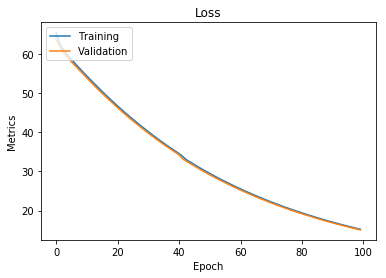

In [30]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [32]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.6241998  0.58920246 0.59951013 0.5381867  0.59659874 0.6018089
  0.60332596 0.54376924 0.59693044 0.56208456 0.66025513 0.47960275
  0.56968504 0.54700416 0.58517784 0.5329204  0.57287234 0.57371104
  0.6166224  0.6004933  0.60104    0.55080086]
 [0.6356464  0.6000288  0.6101079  0.5476919  0.607543   0.61222625
  0.6138676  0.5527345  0.6079213  0.572114   0.6718963  0.48759013
  0.58001274 0.55698776 0.59606165 0.541101   0.5829089  0.5828304
  0.62774223 0.6108757  0.61196804 0.56023246]
 [0.6426261  0.6064425  0.61623925 0.55336154 0.61409557 0.618242
  0.6201776  0.55796283 0.6144834  0.5780317  0.67878103 0.4923009
  0.5862256  0.56295717 0.6025547  0.54584813 0.58891535 0.5878657
  0.6344197  0.6169987  0.6185937  0.56577736]
 [0.6475467  0.6107789  0.62065965 0.5571815  0.6186019  0.6224816
  0.62456346 0.5612708  0.61883    0.582064   0.6835095  0.49542108
  0.59040964 0.56726706 0.6067136  0.5484913  0.5932414  0.591069
  0.63925403 0.620873   0.6233333  0.5695767 ]
 [0.6

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
import math

buy_list = []
sell_list = []

for j, stock in enumerate(chosen_stocks):
  print(stock)
  sorted_result = sorted(map(lambda x: x[j], result))
  midpt = (sorted_result[-2] + sorted_result[1]) / 2
  upper_threshold = midpt * 1.125
  lower_threshold = midpt * 0.9875
  
  print("Target\tPredict\tConsequence")
  for i, r in enumerate(result):
    prediction = r[j].item()
    target = y_test[i][j].item()
    buy_or_sell = 1 if prediction > upper_threshold else (-1 if prediction < lower_threshold else 0)
    if prediction > upper_threshold:
      buy_list.append({'month_id': i + 223, 'QAId': stock})
    if prediction < lower_threshold:
      sell_list.append({'month_id': i + 223, 'QAId': stock})
    
    to_print = str(target) + "\t" + str(buy_or_sell)
    if (buy_or_sell == -1 and target == 0) or (buy_or_sell == 1 and target == 1):
      print(to_print + "\tGain")
    elif (buy_or_sell == -1 and target == 1) or (buy_or_sell == 1 and target == 0):
      print(to_print + "\tLoss")
    else:
      print(to_print + "\tNothing")
  print("\n")

print(buy_list)
print(sell_list)

AAPL
Target	Predict	Consequence
1.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	-1	Gain
1.0	-1	Loss
0.0	-1	Gain
1.0	-1	Loss
0.0	-1	Gain
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
0.0	-1	Gain
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
1.0	0	Nothing


ADM
Target	Predict	Consequence
1.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
0.0	-1	Gain
0.0	-1	Gain
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
0.0	-1	Gain
0.0	-1	Gain
1.0	-1	Loss
0.0	-1	Gain
1.0	-1	Loss
0.0	-1	Gain
1.0	-1	Loss
0.0	0	Nothing


AFL
Target	Predict	Consequence
1.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
0.0	0	Nothing
0.0	0	Nothing
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss
1.0	-1	Loss


In [34]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"]).sort_values(["month_id"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"]).sort_values(["month_id"])
dfBuy.head(5)

,month_id,QAId


In [ ]:
dfSell.head(5)

In [ ]:
filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.csv"
filename_output_sell = "./" + filename_base + "_output_sell.csv"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)